In [1]:
!pip install k2
!python3 -m torch.utils.collect_env

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 MB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.4/887.4 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 3.9 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0+cu118
    Uninstalling torch-2.0.0+cu118:
      Successfully uninstalled torch-2.0.0+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.15.1+cu118 requires torch==2.0.0, but you have torch 1.13.1 

In [2]:
import torch
import numpy as np
import _k2
import k2
import torch.nn.functional as F
import math
import time

In [6]:
def log_substraction_exp(a, b):
    """ return (a.exp() - b.exp()).log(): a numeracal safe implementation """
    ans = torch.ones_like(a) * float("-inf")

    # avoid -inf in input
    mask1 = torch.logical_and(~torch.isinf(a), ~torch.isinf(b))
    a_ = torch.where(mask1, a, -1.0) # avoid any operation on -inf
    b_ = torch.where(mask1, b, -2.0)

    # avoid -inf in output: need to be very small as these values would be picked by mask1
    ans_tmp = b_ + ((a_-b_).exp() - 1).log()
    a_ = torch.where(torch.isinf(ans_tmp), -2000.0, a_)
    b_ = torch.where(torch.isinf(ans_tmp), -2001.0, b_)

    ans1 = b_ + ((a_-b_).exp() - 1).log()
    ans = torch.where(mask1, ans1, ans)
 
    mask2 = torch.logical_and(~torch.isinf(a), torch.isinf(b))
    ans = torch.where(mask2, a, ans)

    return ans

In [4]:
BEAM_SIZE=5
class BPECTC(torch.nn.Module):
    def __init__(self, 
                 odim, 
                 eprojs, 
                 dropout_rate, 
                 reduce=True,
                 log_semiring=True):
        super().__init__()
        # common CTC settings
        self.dropout_rate = dropout_rate
        self.loss = None
        self.ctc_lo = torch.nn.Linear(eprojs, odim)
        self.probs = None
        self.reduce = reduce
        self.log_semiring = log_semiring

    def forward(self, hs_pad, hlens, ctc_graphs):
        """
        hs_pad: [B, T, D], encoder output;
        hlens: [B], effective length of each encoder output
        ctc_graphs: list of matrix that specify ctc_graphs
        """
        batch_size = hs_pad.size(0)
     
        supervision = torch.stack([torch.arange(batch_size),
                                   torch.zeros(batch_size),
                                   hlens.cpu()], dim=1).int()
        indices = torch.argsort(supervision[:, 2], descending=True)
        supervision = supervision[indices]

        nnet_output = self.ctc_lo(F.dropout(hs_pad, p=self.dropout_rate))
        nnet_log_prob = F.log_softmax(nnet_output, dim=-1)

        dense_fsa_vec = k2.DenseFsaVec(nnet_log_prob, supervision)
        #print(dense_fsa_vec)
        #print(",,,,,")

        ctc_graphs = self.revise_ctc_graphs_1(ctc_graphs, indices).requires_grad_(False)
 
        lats = k2.intersect_dense(ctc_graphs, dense_fsa_vec, BEAM_SIZE)
        forward_scores = - lats.get_tot_scores(use_double_scores=True, 
                                               log_semiring=self.log_semiring)
        #print(forward_scores)

        if self.reduce:
            forward_scores = forward_scores.mean()
        else:
            forward_scores = forward_scores.sum()

        # To be compatilble with previous ctc loss: make a recored
        self.probs = F.softmax(nnet_output, dim=-1)
        self.loss = forward_scores 
        return forward_scores

    def revise_ctc_graphs(self, mats,indices):
        """
        The ctc graphs should be revised to be compatible with other CTC implementation.
        We assume:
        (1) The phone 'sil' is never used so the sil_prob of 'lang' is always zero.
        (2) After deleting the 'sil' in the ilabel table, the remained output units are 
            identical with the 'char_list' defined in output dictionary
        """
        ctc_graphs = []
        for mat in mats:
            assert not torch.any(mat[:, 2] == 1), "No sil should be used in CTC graph"
            mat[:, 2] = torch.where(mat[:, 2] <= 0, mat[:, 2], mat[:, 2] - 1) 
            ctc_graph = k2.Fsa.from_dict({"arcs": mat.detach()})
            ctc_graphs.append(ctc_graph)
        return k2.create_fsa_vec(ctc_graphs)
    def revise_ctc_graphs_1(self,mats,indices):
        ctc_graphs = []
        for mat in mats:
            ctc_graph = k2.Fsa.from_str(mat)
            ctc_graphs.append(ctc_graph)
            
        return k2.create_fsa_vec(ctc_graphs)
        
    # Copy from ctc.py
    def softmax(self, hs_pad):
        self.probs = F.softmax(self.ctc_lo(hs_pad), dim=-1)
        return self.probs

    def log_softmax(self, hs_pad):
        return F.log_softmax(self.ctc_lo(hs_pad), dim=-1)

    def argmax(self, hs_pad):
        return torch.argmax(self.ctc_lo(hs_pad), dim=-1)

In [5]:
#bayesctc
class BayesianCTC(BPECTC):
    def __init__(self,
                 odim,
                 eprojs,
                 dropout_rate,
                 reduce=True,
                 log_semiring=True,
                 risk_strategy="time",
                 risk_start=0.0,
                 risk_factor=0.0,
                 direction="right",
                 aggregate="time",
                 den_scale=0.0,
                 path_constraint_delay=0,
    ):
        super().__init__(odim, eprojs, dropout_rate, reduce, log_semiring)
                
        self.strategy = risk_strategy
        self.risk_factor = risk_factor
        self.aggregate = aggregate
        self.den_scale = den_scale 
        self.path_constraint = path_constraint_delay > 0
        self.path_constraint_delay = path_constraint_delay

        assert 0.0 <= den_scale <= 1.0
      
        assert risk_factor >= 0.0
        assert ("time" in aggregate and "time" in risk_strategy) or \
               ("char" in aggregate and "char" in risk_strategy), \
               f"aggregate is {aggregate} ; risk_strategy is {risk_strategy}"

        # If true, use the occupation probability as the grouping strategy
        self.group_as_occupation = risk_strategy in ["char_align"]
   
    def forward(self, hs_pad, hlens, ys_pad, ali):
 
        # As required by k2, reorder by hlens in descending order
        indices = torch.argsort(hlens, descending=True)
        hlens, hs_pad, ys_pad = hlens[indices], hs_pad[indices], ys_pad[indices]
        if isinstance(ali, torch.Tensor) and ali.dim() == 2:
            ali = ali[indices]
        
        # nnet_output
        nnet_output = self.ctc_lo(F.dropout(hs_pad, p=self.dropout_rate))
        # nnet_output.register_hook(grad_plot_hook) # to check the gradient
        nnet_output = F.log_softmax(nnet_output, dim=-1)
        
        # compute the loss for each utterance
        loss = self.forward2(nnet_output, hlens, ys_pad, ali)
        # recover the original order
        indices2 = torch.argsort(indices)
        loss = loss[indices2]

        return loss.mean()
 
    def forward2(self, nnet_output, hlens, ys_pad, ali):
        B, T, D = nnet_output.size()

        # (1) build DenseFsaVec
        supervision = torch.stack([torch.arange(B),
                                   torch.zeros(B),
                                   hlens.cpu()], dim=1).int()

        dense_fsa_vec = k2.DenseFsaVec(nnet_output, supervision)

        # (3) Intersection to get lattice and corresponding arc_maps
        ys = [[x for x in y if x != -1] for y in ys_pad.cpu().tolist()]
        ctc_graphs = k2.ctc_graph(ys).to(nnet_output.device)
        olens = torch.Tensor([len(y) for y in ys]).to(nnet_output.device).long()
        U = max(olens)

        lats = k2.intersect_dense(ctc_graphs, dense_fsa_vec, BEAM_SIZE,
                   seqframe_idx_name="seqframe_idx",
                   frame_idx_name="frame_idx",
        )

        # Since arc_maps are not accessible for K2 user API, we do the second intersection
        # with _k2 object to obtain them
        ragged_lat, arc_map_a, arc_map_b = _k2.intersect_dense(
          a_fsas=ctc_graphs.arcs,
          b_fsas=dense_fsa_vec.dense_fsa_vec,
          a_to_b_map=None,
          output_beam=BEAM_SIZE
        )

        if self.path_constraint:
            ali = ali // 4 + self.path_constraint_delay # due to subsampling; should avoid this hard code
            with torch.no_grad():
                arc_mask = self.get_constraint_ctc_mask(
                    ctc_graphs, dense_fsa_vec, arc_map_a, arc_map_b, ali,
                )
            lats.scores = torch.where(arc_mask, -10000.0, lats.scores.double()).float()
            return - lats.get_tot_scores(True, True)

        # (5) Find all states whose incoming label is non-blank 
        with torch.no_grad():
            # Find all index from two side to ensure safety.
            # You may disable either side to make it faster, after we are sure they are identical
            # state_idx_f, u_idx_f, t_idx_f, fsa_idx_f = self.find_forward_index2( 
            #       ragged_lat, ctc_graphs, dense_fsa_vec, arc_map_a, arc_map_b, lats.frame_idx
            # )
            
            state_idx, u_idx, t_idx, fsa_idx = self.find_backward_index2(
                  ragged_lat, ctc_graphs, dense_fsa_vec, arc_map_a, arc_map_b, lats.frame_idx
            )
            # assert torch.all(state_idx_f == state_idx)
            # assert torch.all(u_idx_f == u_idx)
            # assert torch.all(t_idx_f == t_idx)
            # assert torch.all(fsa_idx_f == fsa_idx)

        # (6) Probability of each path group
        forward_scores  = lats.get_forward_scores(True, True)
        backward_scores = lats.get_backward_scores(True, True)

        alpha_ = forward_scores[state_idx]
        alpha = torch.ones([B, U, T]).double().to(nnet_output.device) * float('-inf')
        alpha[fsa_idx, u_idx, t_idx] = alpha_

        beta_ = backward_scores[state_idx]
        beta = torch.ones([B, U, T]).double().to(nnet_output.device) * float('-inf')
        beta[fsa_idx, u_idx, t_idx] = beta_

        if self.group_as_occupation:
            loss_state = alpha + beta
        else:
            p_idx = ys_pad[fsa_idx, u_idx].long()
            p_ = nnet_output[fsa_idx, t_idx, p_idx].double()
            p = torch.ones([B, U, T]).double().to(nnet_output.device) * float('-inf')
            p[fsa_idx, u_idx, t_idx] = p_
       
            beta_prime = log_substraction_exp(beta[:, :, :-1], beta[:, :, 1:] + p[:, :, 1:])
            beta_prime = torch.cat([beta_prime, beta[:, :, -1:]], dim=-1)

            loss_state = alpha + beta_prime

        # (7) Bayeisan Risk function.
        loss_state = loss_state + self.get_risk_scores(loss_state, hlens, olens, ali)
        loss_state = torch.where(torch.isnan(loss_state), float('-inf'), loss_state) # should never see nan

        # (8) Aggregate scores along time or char axis
        if self.aggregate in ["time", "time_whole"]:
            loss_u = torch.logsumexp(loss_state, dim=2)
            if self.den_scale > 0.0:
                loss_u = loss_u - self.den_scale * lats.get_tot_scores(True, True).unsqueeze(1)
            mask = torch.isinf(loss_u)
            if self.aggregate in ["time_whole"]:
                loss_fsas = torch.where(mask, 0.0, loss_u).sum(1) / (~mask).double().sum(1)
            elif self.aggregate == "time":
                loss_fsas = loss_u[torch.arange(B).long(), (~mask).long().sum(1)-1]

        elif self.aggregate in ["char", "char_whole"]:
            loss_t = torch.logsumexp(loss_state, dim=1)
            mask = torch.isinf(loss_t)
            if self.aggregate == "char_whole":
                loss_fsas = torch.where(mask, 0.0, loss_t).sum(1) / (~mask).double().sum(1)
            elif self.aggregate == "char":
                loss_fsas = loss_t[torch.arange(B).long(), (~mask).long().sum(1)-1]
        
        else:
            raise NotImplementedError 

        # Fix the invalid loss: input length < output length
        # This will happen when the label is (wrongly) too long and the inter_ctc has trimmed too harsh
        loss_fsas = torch.where(hlens < olens, 0.0, loss_fsas)
        if torch.any(hlens < olens):
            print(f"Invalid data: input shorter than output with data index: {(hlens < olens).nonzero()}")

        # (10) Info for debug   
        if torch.any(torch.isinf(loss_fsas)):
            err_idx = torch.nonzero(torch.isinf(loss_fsas).int()).squeeze(0)
            print("An bad case detected. Override so the training can continue. debug info: ")
 
        return - loss_fsas # for minimization

    def get_risk_scores(self, loss_state, hlens, olens, ali):
        """ Add the bayesian risk in multiple ways """
        B, U, T = loss_state.size()

        if self.strategy == "time": 
            risk = torch.arange(1, T+1, device=loss_state.device).unsqueeze(0).unsqueeze(0).repeat(B, U, 1)
            risk = risk / hlens.unsqueeze(1).unsqueeze(1) * self.risk_factor
             
        elif self.strategy == "time_relative":
            risk = torch.arange(1, T+1, device=loss_state.device).unsqueeze(0).unsqueeze(0).repeat(B, U, 1)
            max_stamp = torch.argmax(loss_state, dim=2, keepdim=True)
            risk = (risk - max_stamp) / hlens.unsqueeze(1).unsqueeze(1) * self.risk_factor

        elif self.strategy == "char_align":
            ali = ali // 4 # sub-sampling
            torch.set_printoptions(threshold=1e8)
            risk = torch.arange(1, T+1, device=loss_state.device).unsqueeze(0).unsqueeze(0).repeat(B, U, 1)
            risk = torch.abs(risk - ali.unsqueeze(2)) / hlens.unsqueeze(1).unsqueeze(1) * self.risk_factor
            print("risk is : ", risk, self.risk_factor)
        else:
            raise NotImplementedError
        return - risk        

    def find_forward_index2(self, ragged_lat, a_fsas, b_fsas, arc_map_a, arc_map_b, frame_idx):
        """ Find all states whose scores are exact alpha(t,u) 
            Return: state_idx, u_idx, t_idx, fsa_idx
        """

        # (1) Using incoming format to compute alphas
        ragint_lat = k2.Fsa(ragged_lat)._get_incoming_arcs()
        ragint_graph = a_fsas._get_incoming_arcs()

        # (2) For CTC graphs: Find all arc_ids for the incoming arcs of odd-id states
        graph_arc_id_start = ragint_graph.shape.row_splits(2)[1::2]
        graph_arc_id_end   = ragint_graph.shape.row_splits(2)[2::2]
        graph_arc_ids = [torch.arange(graph_arc_id_start[i], graph_arc_id_end[i])
                             for i in range(len(graph_arc_id_end)) \
                             if 2*(i+1) not in ragint_graph.shape.row_splits(1)[1:].cpu().tolist()] 
        graph_arc_ids = torch.cat(graph_arc_ids).to(a_fsas.device)
        graph_arc_ids = ragint_graph.values.long()[graph_arc_ids]

        # (3) For lattice: find the corresponding arcs in lattice
        lat_arc_ids = (graph_arc_ids.unsqueeze(0) == arc_map_a.unsqueeze(1)).int().sum(dim=-1) # very memory consuming
        # start, parts, interval = 0, [], 3e8 // len(arc_map_a)
        # while start < len(graph_arc_ids):
        #     part_in = graph_arc_ids[start: min(start+interval, len(graph_arc_ids))]
        #     part_out = (part_in.unsqueeze(0) == arc_map_a.unsqueeze(1)).int().sum(dim=-1)
        #     parts.append(part_out)
        #     start += interval
        # lat_arc_ids = torch.cat(parts, dim=0)
        lat_arc_ids = lat_arc_ids.bool().nonzero(as_tuple=True)[0]

        # (4) For lattice: find the corresponding states in lattice
        state_ids = ragint_lat.shape.row_ids(2)[ragint_lat.values.long()]
        state_ids = torch.unique(state_ids[lat_arc_ids]).long()

        # (5) Find the fsa-ids
        fsa_idx = ragged_lat.shape().row_ids(1)[state_ids].long()

        # (6) Find the t-idx
        t_idx = arc_map_b[(ragint_lat.shape.row_splits(2)[state_ids]).long()] // b_fsas.dense_fsa_vec.scores_dim1()
        t_idx = (t_idx - b_fsas.dense_fsa_vec.shape().row_splits(1)[:-1][fsa_idx]).long()

        # (7) Find the u-idx
        lat_arc_ids = ragint_lat.shape.row_splits(2)[state_ids].long()
        lat_arc_ids = ragint_lat.values.long()[lat_arc_ids]
        graph_arc_ids = arc_map_a[lat_arc_ids].long()
        u_idx = (a_fsas.arcs.values()[graph_arc_ids][:, 1] - 1).long() // 2

        return state_ids, u_idx, t_idx, fsa_idx

    def find_backward_index2(self, ragged_lat, a_fsas, b_fsas, arc_map_a, arc_map_b, frame_idx):
        """ Find all states whose scores are exact beta(t,u)
            Return state_idx, u_idx, t_idx, fsa_idx

        """     
        # (1) Get the shape of graphs and lattice
        ragint_lat = k2.Fsa(ragged_lat).arcs.shape()
        ragint_graph = a_fsas.arcs.shape()

        # (2) For CTC graphs: Find all arc_ids for the incoming arcs of odd-id states
        graph_arc_id_start = ragint_graph.row_splits(2)[1::2]
        graph_arc_id_end   = ragint_graph.row_splits(2)[2::2]
        graph_arc_ids = [torch.arange(graph_arc_id_start[i], graph_arc_id_end[i])
                             for i in range(len(graph_arc_id_end))]
        graph_arc_ids = torch.cat(graph_arc_ids).to(a_fsas.device)

        # (3) For lattice: find the corresponding arcs in lattice: the 2-dim tensor can be very large
        # lat_arc_ids = (graph_arc_ids.unsqueeze(0) == arc_map_a.unsqueeze(1)).int().sum(dim=-1)
        start, parts, interval = 0, [], int(2e7 / len(graph_arc_ids))
        while start < len(arc_map_a):
            part_in = arc_map_a[start: min(start+interval, len(arc_map_a))]
            part_out = (graph_arc_ids.unsqueeze(0) == part_in.unsqueeze(1)).int().sum(dim=-1)
            parts.append(part_out)
            start += interval
        lat_arc_ids = torch.cat(parts, dim=0)
        lat_arc_ids = lat_arc_ids.bool().nonzero(as_tuple=True)[0]

        # (4) For lattice: find the corresponding states in lattice
        state_ids = torch.unique(ragint_lat.row_ids(2)[lat_arc_ids]).long()

        # (5) Find the fsa-ids
        fsa_idx = ragged_lat.shape().row_ids(1)[state_ids].long()

        # (6) Find the t-idx
        t_idx = arc_map_b[(ragint_lat.row_splits(2)[state_ids]).long()] // b_fsas.dense_fsa_vec.scores_dim1()
        t_idx = (t_idx - b_fsas.dense_fsa_vec.shape().row_splits(1)[:-1][fsa_idx]).long() - 1

        # (7) Find the u-idx
        lat_arc_ids = ragint_lat.row_splits(2)[state_ids].long()
        graph_arc_ids = arc_map_a[lat_arc_ids].long()
        u_idx = (a_fsas.arcs.values()[graph_arc_ids][:, 0] - 1).long() // 2

        return state_ids, u_idx, t_idx, fsa_idx

    def get_constraint_ctc_mask(self, ctc_graph, dense_fsa_vec, arc_map_a, arc_map_b, ali):
        blank_state_u_id = -1 
        safe_t = 10000
        num_fsas = len(ctc_graph.arcs.row_splits(1)) - 1

        ## Find the index of u, b, t for each lattice arc
        # find the dst state-id for each ctc_graph arc
        arc_to_dst = ctc_graph.as_dict()["arcs"][2 * num_fsas + 4:].view(-1, 4)[:, 1].long()
       
        # even states are the blank states; odd-states are the non-blank states
        u_idx = torch.where(arc_to_dst % 2 == 0, blank_state_u_id, (arc_to_dst - 1) // 2)

        # the ending states should also not be considered
        ctc_ragged = ctc_graph._get_incoming_arcs()
        inverse_shape = ctc_ragged.shape
        incoming_arc_start = inverse_shape.row_splits(2)[inverse_shape.row_splits(1)[1:].long() - 1 ]
        incoming_arc_end   = inverse_shape.row_splits(2)[inverse_shape.row_splits(1)[1:].long()]
        incoming_arcs = [torch.arange(incoming_arc_start[i], incoming_arc_end[i]) for i in range(num_fsas)]
        incoming_arcs = torch.cat(incoming_arcs).long()
        incoming_arcs = ctc_ragged.values[incoming_arcs].long()
        u_idx[incoming_arcs] = blank_state_u_id

        # u_id: non-blank token id of each lattice arc
        u_idx = u_idx[arc_map_a.long()]

        # b_idx: batch id of each lattice arc
        fsa_boundaries = ctc_graph.arcs.shape().row_splits(2).long()[ctc_graph.arcs.shape().row_splits(1).long()]
        arc_ids = torch.arange(ctc_graph.num_arcs, device=ctc_graph.device)
        b_idx = torch.bucketize(arc_ids, fsa_boundaries, right=True) - 1
        b_idx = b_idx[arc_map_a.long()]

        # t_idx: frame id of each lattice arc
        b_shape = dense_fsa_vec.dense_fsa_vec.shape()
        feat_dim, duration = dense_fsa_vec.scores.size(1), dense_fsa_vec.duration + 1
        t_idx = arc_map_b // feat_dim
        t_shift = torch.zeros(1 + len(duration), device=ctc_graph.device, dtype=duration.dtype)
        t_shift[1:] = torch.cumsum(duration, dim=0)
        t_idx = t_idx - t_shift[b_idx]

        ## see if the given arcs should be killed
        # the non-blank arcs whose t_idx is larger than the time threshold should be kill
        t_threshold = ali[b_idx, u_idx]
        t_threshold = torch.where(u_idx == -1, safe_t, t_threshold)
        mask = t_idx > t_threshold

        return mask


In [7]:
odim = 10  # output dimension
eprojs = 16  # encoder projection dimension
dropout_rate = 0.5  # dropout rate
reduce = True  # whether to reduce the loss over the batch
log_semiring = True  # whether to use log semiring
ctc_loss = BPECTC(odim, eprojs, dropout_rate, reduce, log_semiring)

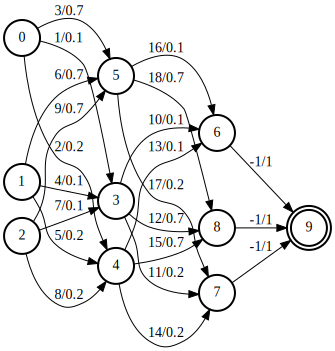

In [8]:
hs_pad = torch.randn(4, 10, 16)  # batch size 32, input length 100, feature dimension 256
hlens = torch.randint(1, 10, (4,))  # effective length of each encoder output

# ctc_graphs = [
#     torch.tensor([[0, 1, 10, 1036831949],[1, 2, 20, 1036831949],[2, 3, 30,1036831949],[2, 4, 40,1036831949],[3, 5, 50,1036831949],[4, 5, 60,1036831949],[5, 6, 70,1036831949],[6,7,-1,1036831949]], dtype=torch.int32)
# ]
s = '''
0 3 1 0.1
0 4 2 0.2
0 5 3 0.7
1 3 4 0.1
1 4 5 0.2
1 5 6 0.7
2 3 7 0.1
2 4 8 0.2
2 5 9 0.7
3 6 10 0.1
3 7 11 0.2
3 8 12 0.7
4 6 13 0.1
4 7 14 0.2
4 8 15 0.7
5 6 16 0.1
5 7 17 0.2
5 8 18 0.7
6 9 -1 1
7 9 -1 1
8 9 -1 1
9
'''
ctc_graph = k2.Fsa.from_str(s)


ctc_graphs = [s]
loss = ctc_loss(hs_pad, hlens, ctc_graphs)

ctc_graph.draw('simple_fsa.svg')

In [9]:
loss

tensor(inf, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [10]:
ctc_loss_bayes =  BayesianCTC(odim, eprojs, dropout_rate, reduce, log_semiring)
B = 5
T = 3
D = 10

# Create some random input tensors.
hs_pad = torch.randn(B, T, D)
hlens = torch.randint(0, T, (B,))
ali = torch.randint(0, T, (B, T))

In [ ]:
# ctc_graphs = [
#     torch.tensor([[0, 1, 10, 1036831949],[1, 2, 20, 1036831949],[2, 3, 30,1036831949],[2, 4, 40,1036831949],[3, 5, 50,1036831949],[4, 5, 60,1036831949],[5, 6, 70,1036831949],[6,7,-1,1036831949]], dtype=torch.int32)
# ]
ctc_graphs = torch.randint(1, odim, (B, 3))
loss = ctc_loss_bayes(hs_pad, hlens, ctc_graphs,ali)